### Goal
- measure the intersection of coding and non coding genes with the nets alignment
- measure the size of the nets alignment compared to Helleia helle genome size
- test for significance of non coding element conservation 

# Material

In [1]:
# chains were downloaded from ucsc, converted from bigBed to bed, and only the first three columns kept, and merged to avoid overlaps
! ls ../data/bb_net/

00_dw_nets.sh
01_covert_bb_to_bed.sh
02_merge_overlaps.sh
GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.net.bb
GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.net.bed
GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.net.merged.bed
GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.synNet.bb
GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.synNet.bed
GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.synNet.merged.bed


In [2]:
nets = {
    'net_main' : '../data/bb_net/GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.net.merged.bed',
    'net_syn' : '../data/bb_net/GCA_963853865.1_ilHelHell1.1.GCA_963855885.1.synNet.merged.bed'  
}

#### Convert gtf to genepred

In [3]:
alias = 'https://hgdownload.soe.ucsc.edu/hubs/GCA/963/853/865/GCA_963853865.1/GCA_963853865.1.chromAlias.txt'
gtf_coding_ann = '../data/annotations/HEHEL1A.FA.gtf'
gtf_coding_ann_gbnames = '../data/annotations/HEHEL1A.FA.gbnames.gtf'

gtf_NONcoding_ann = '../data/annotations/HEHEL1ncA.gtf'
gtf_NONcoding_ann_gbnames = '../data/annotations/HEHEL1ncA.gbnames.gtf'

In [4]:
! chromToUcsc -a $alias -i $gtf_coding_ann  -o $gtf_coding_ann_gbnames
! chromToUcsc -a $alias -i $gtf_NONcoding_ann  -o $gtf_NONcoding_ann_gbnames

In [5]:
gtf_coding_ann_gbnames = '../data/annotations/HEHEL1A.FA.gbnames.gtf'
gtf_NONcoding_ann_gbnames = '../data/annotations/HEHEL1ncA.gbnames.gtf'

genepred_coding = '../data/annotations/HEHEL1A.FA.gbnames.gp'
genepred_NONcoding = '../data/annotations/HEHEL1ncA.gbnames.gp'

In [6]:
! gtfToGenePred $gtf_coding_ann_gbnames $genepred_coding
! gtfToGenePred $gtf_NONcoding_ann_gbnames $genepred_NONcoding

In [7]:
! ls ../data/annotations

HEHEL1A.FA.gbnames.gp  HEHEL1A.FA.gtf         HEHEL1ncA.gbnames.gtf
HEHEL1A.FA.gbnames.gtf HEHEL1ncA.gbnames.gp   HEHEL1ncA.gtf


In [8]:
anns = {
    'coding' : '../data/annotations/HEHEL1A.FA.gbnames.gp',
    'NONcoding' : '../data/annotations/HEHEL1ncA.gbnames.gp'
}

# Net size

In [9]:
import pandas as pd
import pyranges as pr

In [10]:
genome_size = pd.read_csv('https://hgdownload.soe.ucsc.edu/hubs/GCA/963/853/865/GCA_963853865.1/GCA_963853865.1.chrom.sizes.txt', sep = '\t', header = None)
genome_size = genome_size[1].sum()
genome_size

547321747

In [11]:
net_dic = {}

for net in nets:
    gr = pr.read_bed(nets[net])
    total_size = (gr.End - gr.Start).sum()

    net_dic[net] = {'size' : total_size,
                    'genome_perc' : round((total_size*100)/genome_size, 2)}

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [12]:
net_dic

{'net_main': {'size': 73935348, 'genome_perc': 13.51},
 'net_syn': {'size': 34773926, 'genome_perc': 6.35}}

# Intersection 

In [13]:
! mkdir -p ../results/ann_net_intersection

In [14]:
def intersect_bed_gb(bed, gp, res):
    ! overlapSelect -aggregate -statsOutputAll $bed $gp $res

In [15]:
for ann in anns:
    for net in nets:
        out_file = f'../results/ann_net_intersection/{ann}_overlap_{net}.stat'
        print (f'Generating {out_file}')
        intersect_bed_gb(nets[net], anns[ann], out_file)
        print ('Done! \n')

Generating ../results/ann_net_intersection/coding_overlap_net_main.stat
Done! 

Generating ../results/ann_net_intersection/coding_overlap_net_syn.stat
Done! 

Generating ../results/ann_net_intersection/NONcoding_overlap_net_main.stat
Done! 

Generating ../results/ann_net_intersection/NONcoding_overlap_net_syn.stat
Done! 



#### Analysis

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
overlaps = ! ls ../results/ann_net_intersection/
overlaps = ['../results/ann_net_intersection/'+x for x in overlaps]
overlaps

['../results/ann_net_intersection/NONcoding_overlap_net_main.stat',
 '../results/ann_net_intersection/NONcoding_overlap_net_syn.stat',
 '../results/ann_net_intersection/coding_overlap_net_main.stat',
 '../results/ann_net_intersection/coding_overlap_net_syn.stat']

In [18]:
NONcoding_size = pd.read_csv('../results/ann_net_intersection/NONcoding_overlap_net_main.stat', sep = '\t').inBases.sum()
coding_size = pd.read_csv('../results/ann_net_intersection/coding_overlap_net_main.stat', sep = '\t').inBases.sum()

print (NONcoding_size)
print (coding_size)

3411674
39734665


In [19]:
def get_overlap_size(overlap_stats_path, only_overlapping = False):

    df = pd.read_csv(overlap_stats_path, sep = '\t')

    if only_overlapping:
        df = df[df.inOverBases > 0]
    
    ann_size = df.inBases.sum()
    over_size = df.inOverBases.sum()
    perc_overlap = round((over_size*100)/ann_size, 2)

    return perc_overlap

In [20]:
for o in overlaps:
    p = get_overlap_size(o, only_overlapping = False)
    sample_name = o.split('/')[-1]
    print (f'{sample_name} -> {p}')

NONcoding_overlap_net_main.stat -> 17.23
NONcoding_overlap_net_syn.stat -> 10.88
coding_overlap_net_main.stat -> 63.84
coding_overlap_net_syn.stat -> 55.11


In [21]:
for o in overlaps:
    p = get_overlap_size(o, only_overlapping = True)
    sample_name = o.split('/')[-1]
    print (f'{sample_name} -> {p}')

NONcoding_overlap_net_main.stat -> 42.87
NONcoding_overlap_net_syn.stat -> 42.03
coding_overlap_net_main.stat -> 68.94
coding_overlap_net_syn.stat -> 68.89


In [22]:
overlap_df = pd.DataFrame()

for o in overlaps:
    tmp_df = pd.read_csv(o, sep = '\t')
    sample_name = o.split('/')[-1].strip('.stat')
    ann = sample_name.split('_')[0]
    chain = sample_name.split('_')[-1]
    tmp_df['sample_name'] = sample_name
    tmp_df['ann'] = ann
    tmp_df['chain'] = chain
    
    overlap_df = pd.concat([overlap_df, tmp_df])

In [23]:
overlap_df

,#inId,inOverlap,inOverBases,inBases,sample_name,ann,chain
0,HEHEL1ncA003759T1,0.997,591,593,NONcoding_overlap_net_main,NONcoding,main
1,HEHEL1ncA003760T1,0.727,591,813,NONcoding_overlap_net_main,NONcoding,main
2,HEHEL1ncA003760T2,0.752,591,786,NONcoding_overlap_net_main,NONcoding,main
3,HEHEL1ncA003761T1,0.000,0,1275,NONcoding_overlap_net_main,NONcoding,main
4,HEHEL1ncA003762T1,0.998,919,921,NONcoding_overlap_net_main,NONcoding,main
...,...,...,...,...,...,...,...
22753,HEHEL1A010867T1,0.000,0,234,coding_overlap_net_syn,coding,syn
22754,HEHEL1A006219T1,0.000,0,411,coding_overlap_net_syn,coding,syn
22755,HEHEL1A012450T1,0.000,0,423,coding_overlap_net_syn,coding,syn
22756,HEHEL1A003503T1,0.000,0,663,coding_overlap_net_syn,coding,syn


Text(0.5, 0.98, '% overlap ann/net')

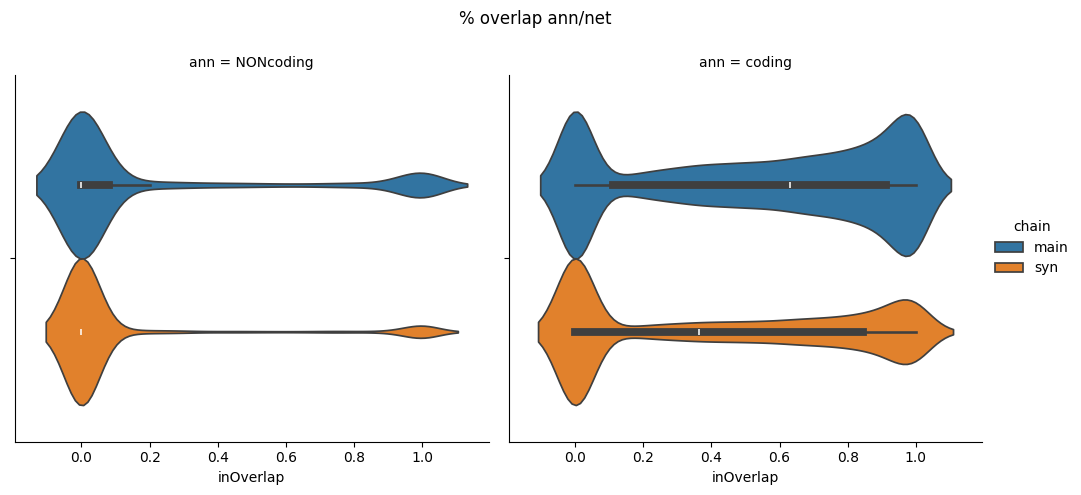

In [24]:
a = sns.catplot(data = overlap_df, x = 'inOverlap',hue = 'chain' ,col = 'ann', kind = 'violin')
a.fig.subplots_adjust(top=0.85)
a.fig.suptitle('% overlap ann/net')

Text(0.5, 0.98, '% overlap ann/net excluding zeros')

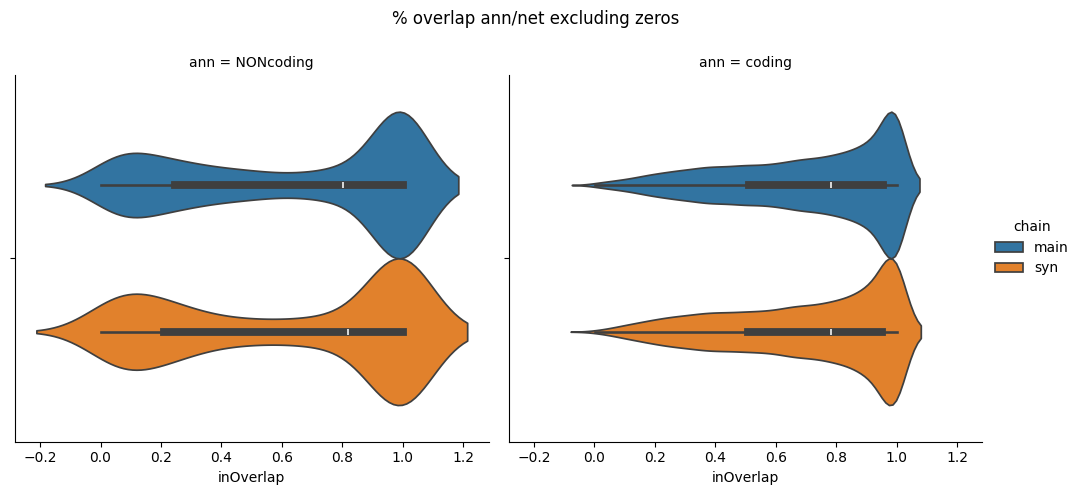

In [25]:
# plt.title('% overlap excluding zeros')
a = sns.catplot(data = overlap_df[overlap_df.inOverlap > 0], x = 'inOverlap',hue = 'chain' ,col = 'ann', kind = 'violin')
a.fig.subplots_adjust(top=0.85)
a.fig.suptitle('% overlap ann/net excluding zeros')

# Test significance of enrichment

In [26]:
from scipy.stats import hypergeom
import numpy as np

In [27]:
# pop size
genome = genome_size

# total success
all_NONcoding = NONcoding_size
all_coding = NONcoding_size

# sample size
synt_net = net_dic['net_syn']['size']
main_net = net_dic['net_main']['size']

# sample success
NONcoding_synt = overlap_df[(overlap_df.ann=='NONcoding') & (overlap_df.chain=='syn')].inOverBases.sum()
NONcoding_main = overlap_df[(overlap_df.ann=='NONcoding') & (overlap_df.chain=='main')].inOverBases.sum()
coding_synt = overlap_df[(overlap_df.ann=='coding') & (overlap_df.chain=='syn')].inOverBases.sum()
coding_main = overlap_df[(overlap_df.ann=='coding') & (overlap_df.chain=='main')].inOverBases.sum()

In [28]:
def get_hyp_pmf_and_pvalue(pop_size, tot_suc, sample_size, sample_suc, title = ''):

    rv = hypergeom(pop_size, tot_suc, sample_size)
    x = np.arange(0, sample_suc+1)
    pmf = rv.pmf(x)
    pv = round(rv.pmf(sample_suc-1), 2) # -1 because I want to include the value itself

    a = sns.lineplot(x = x, y = pmf)
    a.vlines(sample_suc, 0, pmf.max(), lw=2, colors='red')
    a.annotate(pv, (sample_suc, pmf.max()))
    a.set_ylabel('pmf')
    a.set_xlabel('bases in the net')
    a.set_title(title)
    plt.show()

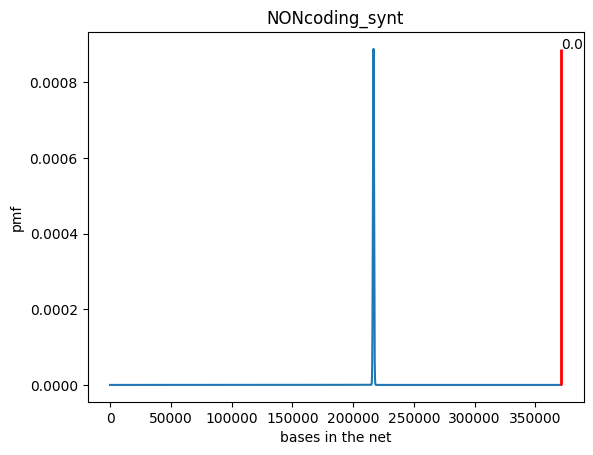

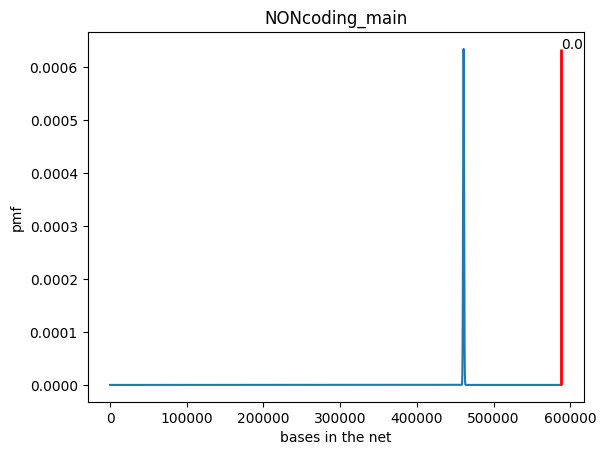

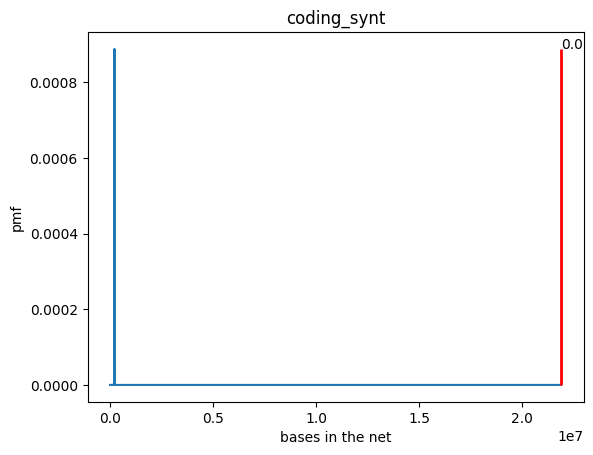

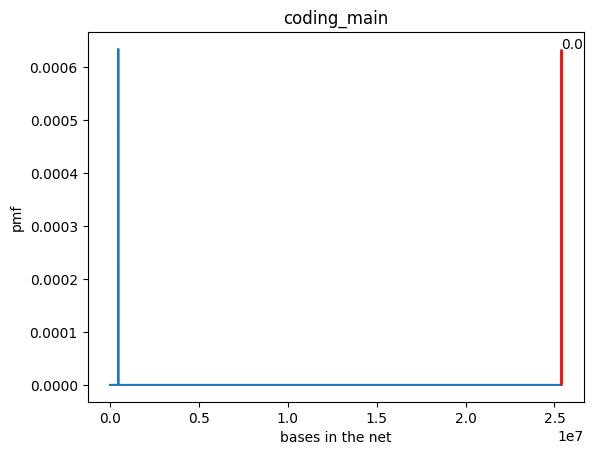

In [29]:
get_hyp_pmf_and_pvalue(genome, all_NONcoding, synt_net, NONcoding_synt, title = 'NONcoding_synt')
get_hyp_pmf_and_pvalue(genome, all_NONcoding, main_net, NONcoding_main, title = 'NONcoding_main')
get_hyp_pmf_and_pvalue(genome, all_coding, synt_net, coding_synt, title = 'coding_synt')
get_hyp_pmf_and_pvalue(genome, all_coding, main_net, coding_main, title = 'coding_main')

# Summary values

In [30]:
print ('genome_size:', genome_size, 'bp')
print ('\nNet stats')
print (f'main net: {net_dic['net_main']['size']}bp ({net_dic['net_main']['genome_perc']}% of the genome)')
print (f'synteny net: {net_dic['net_syn']['size']}bp ({net_dic['net_syn']['genome_perc']}% of the genome)')
print ('\nAnn stats')
print (f'NON coding annotation (exon only): {NONcoding_size}bp ({round(NONcoding_size*100/genome_size,2)})% of the genome')
print (f'coding annotation (exon only): {coding_size}bp ({round(coding_size*100/genome_size,2)})% of the genome')
print ('\nIntersection stats')
for o in overlaps:
    p = get_overlap_size(o, only_overlapping = False)
    sample_name = o.split('/')[-1]
    print (f'{sample_name} -> {p}')

genome_size: 547321747 bp

Net stats
main net: 73935348bp (13.51% of the genome)
synteny net: 34773926bp (6.35% of the genome)

Ann stats
NON coding annotation (exon only): 3411674bp (0.62)% of the genome
coding annotation (exon only): 39734665bp (7.26)% of the genome

Intersection stats
NONcoding_overlap_net_main.stat -> 17.23
NONcoding_overlap_net_syn.stat -> 10.88
coding_overlap_net_main.stat -> 63.84
coding_overlap_net_syn.stat -> 55.11


# Conclusion
- less than 20% of the lnc bases are in aligned regions (17% with main net, 10% with synteny net, protein coding is ~60%)
- Those lncRNA that falls in aligned regions, have ~80% of their exons overlapping the net 
- genome to genome aligned regions are enriched of lncRNA locus, more enrichment when considering syntenic nets
- aligned regions are more enriched of protein codinf genes than long non coding RNAs
### Possible limits
- multiple isoforms
- only CDS are considered